In [3]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cv2 import imread, resize
import tensorflow as tf
#import ntpath
import csv

In [4]:
def open_img(img_fname):
    img = cv2.imread(img_fname, cv2.IMREAD_GRAYSCALE)
    return img

In [5]:
list_feature_name = ['histype','WT1','ER','PR']#histype
len_feature_list = len(list_feature_name)

list_radinfo_name = ['age','mean0','sd0','sd2','sd3','sd4','sd5','sd6','entropy0','entropy2','entropy3','entropy4','entropy5','entropy6','mpp0','mpp2','mpp3','mpp4','mpp5','mpp6']
    #['age','staging','CA125','mean0','sd0','entropy0','mpp0','skewness0','kurtosis0','mean2','sd2','entropy2','mpp2',\
    #                 'skewness2','kurtosis2','mean3','sd3','entropy3','mpp3','skewness3','kurtosis3','mean4','sd4',\
    #                 'entropy4','mpp4','skewness4','kurtosis4','mean5','sd5','entropy5','mpp5','skewness5','kurtosis5',\
    #                 	'mean6','sd6','entropy6','mpp6','skewness6','kurtosis6']#
len_radinfo_list = len(list_radinfo_name)

In [6]:
def list_data(label_fname,list_feature_name, list_radinfo_name, folder_path):
    csvfile =  open(label_fname)
    reader = csv.DictReader(csvfile)  # type: DictReader
    csv_num_IM = []
    csv_num_XML = []
    csv_num_SEG = []
    csv_feature = []
    csv_radinfo = []
    len_feature_list = len(list_feature_name)
    len_radinfo_list = len(list_radinfo_name)
    for row in reader:
        if row['patientname'][-3:].isdigit():
            csv_num_IM.append(os.path.join(folder_path, row['patientname'][-3:]+'.jpeg'))
            csv_num_XML.append(os.path.join(folder_path, row['patientname'][-3:]+'.xml'))            
            csv_num_SEG.append(os.path.join(folder_path, row['patientname'][-3:]+'y.jpeg'))             
            csv_feature.append([int(row[list_feature_name[i]]) for i in range(len_feature_list)]) 
            csv_radinfo.append([float(row[list_radinfo_name[i]]) for i in range(len_radinfo_list)])
    return csv_num_IM, csv_num_SEG, csv_num_XML, csv_feature, csv_radinfo

In [7]:
def findcenter2d(img):
    h_pos = np.array(np.where(np.sum(img,axis=(1,2))>0)).squeeze()
    w_pos = np.array(np.where(np.sum(img,axis=(0,2))>0)).squeeze()
    if not h_pos.size:
        h_pos = img.shape[0]/2
    if not w_pos.size:
        w_pos = img.shape[1]/2
    return int(np.mean(h_pos)), int(np.mean(w_pos))

def findbox2d(img):
    h_pos = np.array(np.where(np.sum(img,axis=(1,))>0)).squeeze()
    w_pos = np.array(np.where(np.sum(img,axis=(0,))>0)).squeeze()
    return h_pos, w_pos
    
def cropbox2d(img,mask):
    h_pos, w_pos = findbox2d(mask)
    return img[h_pos[0]:h_pos[-1],w_pos[0]:w_pos[-1]],\
           mask[h_pos[0]:h_pos[-1],w_pos[0]:w_pos[-1]]

In [8]:
def resize2d(img,cropshape):
    h,w = img.shape
    return cv2.resize(img[cropshape[0]:cropshape[1],:],(h,w))
    
def resize2d_2(img,squeezeshape):
    h,w = img.shape
    tmp   = cv2.resize(img,(squeezeshape[3]-squeezeshape[2],squeezeshape[1]-squeezeshape[0]))
    tmp_z = np.zeros((h,w))
    tmp_z[squeezeshape[0]:squeezeshape[1], squeezeshape[2]:squeezeshape[3],:] = tmp
    return tmp

def reshape2d(image_tmp, img_height, img_width):
    image_tmp = resize(image_tmp, dsize=(img_width, img_height), interpolation=cv2.INTER_LINEAR)
    return image_tmp

def im_norm(image_tmp):
    image_tmp = (image_tmp - np.min(image_tmp)) / (np.max(image_tmp) - np.min(image_tmp))
    return image_tmp

def open_img_reshape2d(fname, img_height, img_width):
    image_tmp = open_img(fname).astype('float32')#
    return reshape2d(image_tmp, img_height, img_width)


def rand_rotate_imgseg_2d(image,label, img_height, img_width, angxy=15):
    #rotation along xy
    ima = image
    imb = label
    rand_ang = np.random.randint(-angxy,angxy,size=1)
    Mtx = cv2.getRotationMatrix2D((img_height//2,img_width//2),rand_ang,1)
    image = cv2.warpAffine(ima,Mtx,( img_height, img_width))
    label = np.round_(cv2.warpAffine(np.float_(imb),Mtx,( img_height, img_width)))
    return image, label

class Data_generator():
    def __init__(self, csv_fname, list_feature_name, list_radinfo_name, dir_im, img_height, img_width, batch_size):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.dir_im = dir_im #get root dir

        self.num_img_type = 1#get number of labels
        self.batch_size = batch_size #get batch size
        self.batch_idx  = 0 #gatch index initialized as 0

        self.img_path, self.seg_path, _, self.feature, self.radinfo = list_data(csv_fname, list_feature_name, list_radinfo_name, dir_im)        
        self.len_feature = len(list_feature_name)
        self.len_radinfo = len(list_radinfo_name)

        self.data_size = len(self.img_path)
        self.batch_idx_max = np.floor_divide(self.data_size,self.batch_size) #max batch size
        self.img_height    = img_height #define the dims of image, image will be resize with this dim
        self.img_width     = img_width

        self.shuffled_idx  = np.arange(self.data_size)
        self.absolute_ind  = 0
        self.repeat_step   = 0
        self.repeat_step_run = 0
        #self.rescale = 1/256.0
        
    #return size of samples
    def __len__(self):
        return self.data_size

    def reset_idx(self):
        self.batch_idx = 0
        self.absolute_ind = 0
        return self
        
    #shuffle the order of all samples
    def shuffle_all(self):
        np.random.shuffle(self.shuffled_idx)
        return self

    #read one batch of images and labels from files 
    def next(self, rand_flip = 0, read_img = 1):
        
        image = np.empty((self.batch_size, self.img_height, self.img_width), dtype='float32')
        seg   = np.empty((self.batch_size, self.img_height, self.img_width), dtype='float32')
        label_feature = np.empty((self.batch_size, self.len_feature), dtype='float32')
        list_radinfo  = np.empty((self.batch_size, self.len_radinfo), dtype='float32')

        #loop for one batch
        for i in range(self.batch_size):
            self.absolute_ind = i + self.batch_size * self.batch_idx
            if self.absolute_ind >= self.data_size:
                self.absolute_ind -= self.data_size
            idx              = self.shuffled_idx[self.absolute_ind]
            label_feature[i] = self.feature[idx]
            list_radinfo[i]  = self.radinfo[idx]
            if read_img:
                image_t     = np.nan_to_num(open_img(self.img_path[idx]))
                image_t     = image_t/np.nanmax(image_t)
                seg_t       = open_img(self.seg_path[idx])
                seg_t     = seg_t/np.nanmax(seg_t)   

                image_t  = reshape2d(image_t, 256, 256)
                seg_t    = reshape2d(seg_t,   256, 256)  
                #image_t,seg_t = cropbox2d(image_t,seg_t)
                image[i] = reshape2d(image_t, self.img_height, self.img_width)
                seg[i]   = reshape2d(seg_t,   self.img_height, self.img_width)             
        #rand_flip
        if rand_flip:
            if np.random.randint(2): #random scaling
                for d in range(self.batch_size):
                    image[d] = (1.0*np.random.random_sample()+0.5)*image[d] + 0.2*np.random.random_sample(image[d].shape)
                    list_radinfo[d] = (0.4*np.random.random_sample(list_radinfo[d].shape)+0.8)*list_radinfo[d] 
            if np.random.randint(2): #random rotation, rand_ang defines the angle
                for d in range(self.batch_size):
                    image[d], seg[d] = rand_rotate_imgseg_2d(image[d],seg[d], self.img_height, self.img_width, angxy=90)
                
        #incease batch index
        self.batch_idx = self.batch_idx + 1
        #once done for one epoch, reset the index 
        if self.batch_idx > self.batch_idx_max:
            self.batch_idx = 0
            self.shuffle_all() #shuffled the order of index for all
            #batch image and labe        
        return image, seg, label_feature, list_radinfo
    def all(self, read_img = 0):
        
        image = np.empty((self.data_size, self.img_height, self.img_width), dtype='float32')
        seg   = np.empty((self.data_size, self.img_height, self.img_width), dtype='float32')
        label_feature = np.empty((self.data_size, self.len_feature), dtype='float32')
        list_radinfo  = np.empty((self.data_size, self.len_radinfo), dtype='float32')

        #loop for one batch
        for i in range(self.data_size):
            label_feature[i] = self.feature[i]
            list_radinfo[i]  = self.radinfo[i]
            if read_img:
                image_t     = np.nan_to_num(open_img(self.img_path[i]))
                image_t     = image_t/np.nanmax(image_t)
                seg_t       = open_img(self.seg_path[i])
                seg_t     = seg_t/np.nanmax(seg_t)   

                image_t  = reshape2d(image_t, 256, 256)
                seg_t    = reshape2d(seg_t,   256, 256)  
                #image_t,seg_t = cropbox2d(image_t,seg_t)
                image[i] = reshape2d(image_t, self.img_height, self.img_width)
                seg[i]   = reshape2d(seg_t,   self.img_height, self.img_width)             

        return image, seg, label_feature, list_radinfo

In [10]:
folder_train_IM = 'Reviewer1_training_set/'
folder_train_SEG = 'Reviewer1_training_set/'

folder_test_IM = 'Reviewer1_validation_set/'
folder_test_SEG = 'Reviewer1_validation_set/'
 
img_dir_list_train, seg_dir_list_train, xml_dir_list_train, feature_dir_list_train, radinfo_dir_list_train\
    = list_data('training.csv',list_feature_name,list_radinfo_name,folder_train_IM)

In [1]:
img_height, img_width = [128, 128]

batch_size = 10
#def __init__(self, csv_fname, list_feature_name, dir_im, img_height, img_width, batch_size, aug_pipe = None):
train_loader   = Data_generator('training.csv', list_feature_name, list_radinfo_name, folder_train_IM, img_height, img_width, batch_size)
test_loader    = Data_generator('testing.csv',  list_feature_name, list_radinfo_name, folder_test_IM, img_height, img_width, batch_size)


print(len(train_loader))
print(len(test_loader))

NameError: name 'Data_generator' is not defined

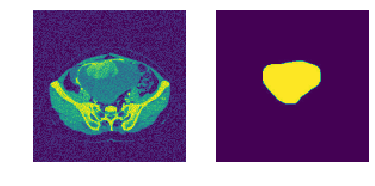

In [9]:
im_train,seg_train,f_train,_ = train_loader.next(rand_flip=1)


f, axarr = plt.subplots(1, 2)
axarr[0].imshow((im_train[0,:,:].squeeze()))
axarr[0].axis('off')
axarr[1].imshow((seg_train[0,:,:].squeeze()))
axarr[1].axis('off')

plt.show()

In [12]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
_,_, train_labels, train_features = train_loader.all()
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

In [14]:
_,_, test_labels, test_features = test_loader.all()
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))


Mean Absolute Error: 0.35


In [16]:
#import matplotlib.pyplot as plt
#plt.plot(np.array(real_y).flatten(), np.array(pred_y).flatten(),'o')

roc_auc = []
fpr = []
tpr = []
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
for i in range( len(list_feature_name)):
    false_pos_rate, true_pos_rate, threshold = metrics.roc_curve(np.array(test_labels)[:,i].flatten(), (np.array(predictions)[:,i].flatten()))
    roc_auc.append(metrics.auc(false_pos_rate, true_pos_rate))
    fpr.append(false_pos_rate)
    tpr.append(true_pos_rate)
print(roc_auc)

[0.6196078431372549, 0.7016666666666667, 0.6896103896103896, 0.650354609929078]


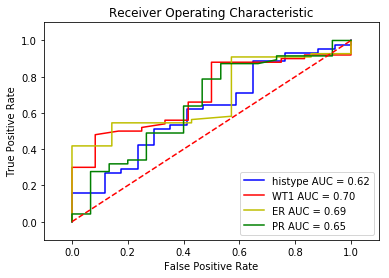

In [ ]:
fig = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr[0], tpr[0], 'b', label=list_feature_name[0] + ' AUC = %0.2f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], 'r', label=list_feature_name[1] +' AUC = %0.2f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], 'y', label=list_feature_name[2] +' AUC = %0.2f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], 'g', label=list_feature_name[3] +' AUC = %0.2f'% roc_auc[3])
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


fig.savefig('roc_rf.png', dpi=fig.dpi)